In [1]:
# train.py converted to notebook
# sudo -E /opt/tljh/user/bin/pip3 install dill
# sudo -E /opt/tljh/user/bin/pip3 install scikit-imageF
# sudo -E /opt/tljh/user/bin/pip3 install imblearn
# sudo -E /opt/tljh/user/bin/pip3 install opencv-python

In [2]:
import pandas as pd
import yaml
import os
import datetime
import random
import dill
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.summary as tf_summary
from imblearn.over_sampling import RandomOverSampler
from math import ceil
from tensorflow.keras.metrics import BinaryAccuracy, CategoricalAccuracy, Precision, Recall, AUC
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorboard.plugins.hparams import api as hp
import sys
sys.path.append('src')
from models.models import *
from visualization.visualize import *
from custom.metrics import F1Score
from data.preprocess import remove_text

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1875683932670039604
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15575951257637008336
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18293452786807977872
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640768640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4906114476970803133
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5"
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
def get_class_weights(histogram, class_multiplier=None):
    '''
    Computes weights for each class to be applied in the loss function during training.
    :param histogram: A list depicting the number of each item in different class
    :param class_multiplier: List of values to multiply the calculated class weights by. For further control of class weighting.
    :return: A dictionary containing weights for each class
    '''
    weights = [None] * len(histogram)
    for i in range(len(histogram)):
        weights[i] = (1.0 / len(histogram)) * sum(histogram) / histogram[i]
    class_weight = {i: weights[i] for i in range(len(histogram))}
    if class_multiplier is not None:
        class_weight = [class_weight[i] * class_multiplier[i] for i in range(len(histogram))]
    print("Class weights: ", class_weight)
    #debug
    print("Class weights type:", type(class_weight))
    return class_weight

In [6]:
def random_minority_oversample(train_set):
    '''
    Oversample the minority class using the specified algorithm
    :param train_set: Training set image file names and labels
    :return: A new training set containing oversampled examples
    '''
    X_train = train_set[[x for x in train_set.columns if x != 'label']].to_numpy()
    if X_train.shape[1] == 1:
        X_train = np.expand_dims(X_train, axis=-1)
    Y_train = train_set['label'].to_numpy()
    sampler = RandomOverSampler(random_state=np.random.randint(0, high=1000))
    X_resampled, Y_resampled = sampler.fit_resample(X_train, Y_train)
    filenames = X_resampled[:, 1]     # Filename is in second column
    label_strs = X_resampled[:, 2]    # Class name is in second column
    print("Train set shape before oversampling: ", X_train.shape, " Train set shape after resampling: ", X_resampled.shape)
    train_set_resampled = pd.DataFrame({'filename': filenames, 'label': Y_resampled, 'label_str': label_strs})
    return train_set_resampled


In [7]:
def train_model(cfg, data, callbacks, verbose=1):
    '''
    Train a and evaluate model on given data.
    :param cfg: Project config (from config.yml)
    :param data: dict of partitioned dataset
    :param callbacks: list of callbacks for Keras model
    :param verbose: Verbosity mode to pass to model.fit_generator()
    :return: Trained model and associated performance metrics on the test set
    '''

    # If set in config file, oversample the minority class
    if cfg['TRAIN']['IMB_STRATEGY'] == 'random_oversample':
        data['TRAIN'] = random_minority_oversample(data['TRAIN'])

    # Create ImageDataGenerators
    train_img_gen = ImageDataGenerator(rotation_range=10, preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    val_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    test_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)

    # Create DataFrameIterators
    img_shape = tuple(cfg['DATA']['IMG_DIM'])
    y_col = 'label_str'
    class_mode = 'categorical'
    train_generator = train_img_gen.flow_from_dataframe(dataframe=data['TRAIN'], directory=cfg['PATHS']['RAW_DATA'],
        x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'],
        class_mode=class_mode, validate_filenames=False)
    val_generator = val_img_gen.flow_from_dataframe(dataframe=data['VAL'], directory=cfg['PATHS']['RAW_DATA'],
        x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'],
        class_mode=class_mode, validate_filenames=False)
    test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'], directory=cfg['PATHS']['RAW_DATA'],
        x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'],
        class_mode=class_mode, validate_filenames=False, shuffle=False)

    # Save model's ordering of class indices
    dill.dump(test_generator.class_indices, open(cfg['PATHS']['OUTPUT_CLASS_INDICES'], 'wb'))

    # Apply class imbalance strategy. We have many more X-rays negative for COVID-19 than positive.
    histogram = np.bincount(np.array(train_generator.labels).astype(int))  # Get class distribution
    class_weight = None
    if cfg['TRAIN']['IMB_STRATEGY'] == 'class_weight':
        class_multiplier = cfg['TRAIN']['CLASS_MULTIPLIER']
        class_multiplier = [class_multiplier[cfg['DATA']['CLASSES'].index(c)] for c in test_generator.class_indices]
        class_weight = get_class_weights(histogram, class_multiplier)

    # Define metrics.
    covid_class_idx = test_generator.class_indices['COVID-19']   # Get index of COVID-19 class
    thresholds = 1.0 / len(cfg['DATA']['CLASSES'])      # Binary classification threshold for a class
    metrics = [CategoricalAccuracy(name='accuracy'),
               Precision(name='precision', thresholds=thresholds, class_id=covid_class_idx),
               Recall(name='recall', thresholds=thresholds, class_id=covid_class_idx),
               AUC(name='auc'),
               F1Score(name='f1score', thresholds=thresholds, class_id=covid_class_idx)]

    # Define the model.
    print('Training distribution: ', ['Class ' + list(test_generator.class_indices.keys())[i] + ': ' + str(histogram[i]) + '. '
           for i in range(len(histogram))])
    input_shape = cfg['DATA']['IMG_DIM'] + [3]
    num_gpus = cfg['TRAIN']['NUM_GPUS']
    #debug
    print("******* GPU:", num_gpus)
    if cfg['TRAIN']['MODEL_DEF'] == 'dcnn_resnet':
        model_def = dcnn_resnet
    elif cfg['TRAIN']['MODEL_DEF'] == 'resnet50v2':
        model_def = resnet50v2
    else:
        model_def = resnet101v2
    if cfg['TRAIN']['CLASS_MODE'] == 'binary':
        histogram = np.bincount(data['TRAIN']['label'].astype(int))
        output_bias = np.log([histogram[i] / (np.sum(histogram) - histogram[i]) for i in range(histogram.shape[0])])
        model = model_def(cfg['NN']['DCNN_BINARY'], input_shape, metrics, 2, output_bias=output_bias, gpus=num_gpus)
    else:
        n_classes = len(cfg['DATA']['CLASSES'])
        histogram = np.bincount(data['TRAIN']['label'].astype(int))
        output_bias = np.log([histogram[i] / (np.sum(histogram) - histogram[i]) for i in range(histogram.shape[0])])
        model = model_def(cfg['NN']['DCNN_MULTICLASS'], input_shape, metrics, n_classes, output_bias=output_bias,
                          gpus=num_gpus)
    #debug
    print("histogram type", type(histogram), histogram)
        
    # Train the model.
    steps_per_epoch = ceil(train_generator.n / train_generator.batch_size)
    val_steps = ceil(val_generator.n / val_generator.batch_size)
    # debug
    print("***** class weight", class_weight)
    class_weight = {0:26.589285714285715, 1:0.07643737166324435}
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=cfg['TRAIN']['EPOCHS'],
                                  validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks,
                                  verbose=verbose, class_weight=class_weight)

    # Run the model on the test set and print the resulting performance metrics.
    test_results = model.evaluate(test_generator, verbose=1)
    test_metrics = {}
    test_summary_str = [['**Metric**', '**Value**']]
    for metric, value in zip(model.metrics_names, test_results):
        test_metrics[metric] = value
        print(metric, ' = ', value)
        test_summary_str.append([metric, str(value)])
    return model, test_metrics, test_generator

In [8]:
#class_weight = {0:26.589285714285715, 1:0.07643737166324435}
#print(class_weight)

In [9]:
def multi_train(cfg, data, callbacks, base_log_dir):
    '''
    Trains a model a series of times and returns the model with the best test set metric (specified in cfg)
    :param cfg: Project config (from config.yml)
    :param data: Partitioned dataset
    :param callbacks: List of callbacks to pass to model.fit()
    :param base_log_dir: Base directory to write logs
    :return: The trained Keras model with best test set performance on the metric specified in cfg
    '''

    # Load order of metric preference
    metric_preference = cfg['TRAIN']['METRIC_PREFERENCE']
    best_metrics = dict.fromkeys(metric_preference, 0.0)
    if 'loss' in metric_preference:
        best_metrics['loss'] = 100000.0

    # Train NUM_RUNS models and return the best one according to the preferred metrics
    for i in range(cfg['TRAIN']['NUM_RUNS']):
        print("Training run ", i+1, " / ", cfg['TRAIN']['NUM_RUNS'])
        cur_callbacks = callbacks.copy()
        cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
        if base_log_dir is not None:
            log_dir = base_log_dir + cur_date
            cur_callbacks.append(TensorBoard(log_dir=log_dir, histogram_freq=1))

        # Train the model and evaluate performance on test set
        new_model, test_metrics, test_generator = train_model(cfg, data, cur_callbacks, verbose=1)

        # Log test set results and images
        if base_log_dir is not None:
            log_test_results(cfg, new_model, test_generator, test_metrics, log_dir)

        # If this model outperforms the previous ones based on the specified metric preferences, save this one.
        for i in range(len(metric_preference)):
            if (((metric_preference[i] == 'loss') and (test_metrics[metric_preference[i]] < best_metrics[metric_preference[i]]))
                    or ((metric_preference[i] != 'loss') and (test_metrics[metric_preference[i]] > best_metrics[metric_preference[i]]))):
                best_model = new_model
                best_metrics = test_metrics
                best_generator = test_generator
                best_model_date = cur_date
                break
            elif (test_metrics[metric_preference[i]] == best_metrics[metric_preference[i]]):
                continue
            else:
                break

    print("Best model test metrics: ", best_metrics)
    return best_model, best_metrics, best_generator, best_model_date


In [10]:
def random_hparam_search(cfg, data, callbacks, log_dir):
    '''
    Conduct a random hyperparameter search over the ranges given for the hyperparameters in config.yml and log results
    in TensorBoard. Model is trained x times for y random combinations of hyperparameters.
    :param cfg: Project config
    :param data: Dict containing the partitioned datasets
    :param callbacks: List of callbacks for Keras model (excluding TensorBoard)
    :param log_dir: Base directory in which to store logs
    :return: (Last model trained, resultant test set metrics, test data generator)
    '''

    # Define HParam objects for each hyperparameter we wish to tune.
    hp_ranges = cfg['HP_SEARCH']['RANGES']
    HPARAMS = []
    HPARAMS.append(hp.HParam('KERNEL_SIZE', hp.Discrete(hp_ranges['KERNEL_SIZE'])))
    HPARAMS.append(hp.HParam('MAXPOOL_SIZE', hp.Discrete(hp_ranges['MAXPOOL_SIZE'])))
    HPARAMS.append(hp.HParam('INIT_FILTERS', hp.Discrete(hp_ranges['INIT_FILTERS'])))
    HPARAMS.append(hp.HParam('FILTER_EXP_BASE', hp.IntInterval(hp_ranges['FILTER_EXP_BASE'][0], hp_ranges['FILTER_EXP_BASE'][1])))
    HPARAMS.append(hp.HParam('NODES_DENSE0', hp.Discrete(hp_ranges['NODES_DENSE0'])))
    HPARAMS.append(hp.HParam('CONV_BLOCKS', hp.IntInterval(hp_ranges['CONV_BLOCKS'][0], hp_ranges['CONV_BLOCKS'][1])))
    HPARAMS.append(hp.HParam('DROPOUT', hp.Discrete(hp_ranges['DROPOUT'])))
    HPARAMS.append(hp.HParam('LR', hp.RealInterval(hp_ranges['LR'][0], hp_ranges['LR'][1])))
    HPARAMS.append(hp.HParam('OPTIMIZER', hp.Discrete(hp_ranges['OPTIMIZER'])))
    HPARAMS.append(hp.HParam('L2_LAMBDA', hp.Discrete(hp_ranges['L2_LAMBDA'])))
    HPARAMS.append(hp.HParam('BATCH_SIZE', hp.Discrete(hp_ranges['BATCH_SIZE'])))
    HPARAMS.append(hp.HParam('IMB_STRATEGY', hp.Discrete(hp_ranges['IMB_STRATEGY'])))

    # Define test set metrics that we wish to log to TensorBoard for each training run
    HP_METRICS = [hp.Metric(metric, display_name='Test ' + metric) for metric in cfg['HP_SEARCH']['METRICS']]

    # Configure TensorBoard to log the results
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams_config(hparams=HPARAMS, metrics=HP_METRICS)

    # Complete a number of training runs at different hparam values and log the results.
    repeats_per_combo = cfg['HP_SEARCH']['REPEATS']   # Number of times to train the model per combination of hparams
    num_combos = cfg['HP_SEARCH']['COMBINATIONS']     # Number of random combinations of hparams to attempt
    num_sessions = num_combos * repeats_per_combo       # Total number of runs in this experiment
    model_type = 'DCNN_BINARY' if cfg['TRAIN']['CLASS_MODE'] == 'binary' else 'DCNN_MULTICLASS'
    trial_id = 0
    for group_idx in range(num_combos):
        rand = random.Random()
        HPARAMS = {h: h.domain.sample_uniform(rand) for h in HPARAMS}
        hparams = {h.name: HPARAMS[h] for h in HPARAMS}  # To pass to model definition
        for repeat_idx in range(repeats_per_combo):
            trial_id += 1
            print("Running training session %d/%d" % (trial_id, num_sessions))
            print("Hparam values: ", {h.name: HPARAMS[h] for h in HPARAMS})
            trial_logdir = os.path.join(log_dir, str(trial_id))     # Need specific logdir for each trial
            callbacks_hp = callbacks + [TensorBoard(log_dir=trial_logdir, profile_batch=0, write_graph=False)]

            # Set values of hyperparameters for this run in config file.
            for h in hparams:
                if h in ['LR', 'L2_LAMBDA']:
                    val = 10 ** hparams[h]      # These hyperparameters are sampled on the log scale.
                else:
                    val = hparams[h]
                cfg['NN'][model_type][h] = val

            # Set some hyperparameters that are not specified in model definition.
            cfg['TRAIN']['BATCH_SIZE'] = hparams['BATCH_SIZE']
            cfg['TRAIN']['IMB_STRATEGY'] = hparams['IMB_STRATEGY']

            # Run a training session and log the performance metrics on the test set to HParams dashboard in TensorBoard
            with tf.summary.create_file_writer(trial_logdir).as_default():
                hp.hparams(HPARAMS, trial_id=str(trial_id))
                model, test_metrics, test_generator = train_model(cfg, data, callbacks_hp, verbose=0)
                for metric in HP_METRICS:
                    if metric._tag in test_metrics:
                        tf.summary.scalar(metric._tag, test_metrics[metric._tag], step=1)   # Log test metric
    return


In [11]:
def log_test_results(cfg, model, test_generator, test_metrics, log_dir):
    '''
    Visualize performance of a trained model on the test set. Optionally save the model.
    :param cfg: Project config
    :param model: A trained Keras model
    :param test_generator: A Keras generator for the test set
    :param test_metrics: Dict of test set performance metrics
    :param log_dir: Path to write TensorBoard logs
    '''

    # Visualization of test results
    test_predictions = model.predict(test_generator, verbose=0)
    test_labels = test_generator.labels
    covid_idx = test_generator.class_indices['COVID-19']
    plt = plot_roc("Test set", test_labels, test_predictions, class_id=covid_idx)
    roc_img = plot_to_tensor()
    plt = plot_confusion_matrix(test_labels, test_predictions, class_id=covid_idx)
    cm_img = plot_to_tensor()

    # Log test set results and plots in TensorBoard
    writer = tf_summary.create_file_writer(logdir=log_dir)

    # Create table of test set metrics
    test_summary_str = [['**Metric**','**Value**']]
    thresholds = cfg['TRAIN']['THRESHOLDS']  # Load classification thresholds
    for metric in test_metrics:
        if metric in ['precision', 'recall'] and isinstance(metric, list):
            metric_values = dict(zip(thresholds, test_metrics[metric]))
        else:
            metric_values = test_metrics[metric]
        test_summary_str.append([metric, str(metric_values)])

    # Create table of model and train config values
    hparam_summary_str = [['**Variable**', '**Value**']]
    for key in cfg['TRAIN']:
        hparam_summary_str.append([key, str(cfg['TRAIN'][key])])
    if cfg['TRAIN']['CLASS_MODE'] == 'binary':
        for key in cfg['NN']['DCNN_BINARY']:
            hparam_summary_str.append([key, str(cfg['NN']['DCNN_BINARY'][key])])
    else:
        for key in cfg['NN']['DCNN_BINARY']:
            hparam_summary_str.append([key, str(cfg['NN']['DCNN_BINARY'][key])])

    # Write to TensorBoard logs
    with writer.as_default():
        tf_summary.text(name='Test set metrics', data=tf.convert_to_tensor(test_summary_str), step=0)
        tf_summary.text(name='Run hyperparameters', data=tf.convert_to_tensor(hparam_summary_str), step=0)
        tf_summary.image(name='ROC Curve (Test Set)', data=roc_img, step=0)
        tf_summary.image(name='Confusion Matrix (Test Set)', data=cm_img, step=0)
    return

In [12]:
def train_experiment(cfg=None, experiment='single_train', save_weights=True, write_logs=True):
    '''
    Defines and trains HIFIS-v2 model. Prints and logs relevant metrics.
    :param experiment: The type of training experiment. Choices are {'single_train'}
    :param save_weights: A flag indicating whether to save the model weights
    :param write_logs: A flag indicating whether to write TensorBoard logs
    :return: A dictionary of metrics on the test set
    '''

    # Load project config data
    if cfg is None:
        cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))

    # Set logs directory
    cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    print(cfg['PATHS']['LOGS'])
    log_dir = cfg['PATHS']['LOGS'] + "training/" + cur_date if write_logs else None
    if not os.path.exists(cfg['PATHS']['LOGS'] + "training\\"):
        os.makedirs(cfg['PATHS']['LOGS'] + "training\\")

    # Load dataset file paths and labels
    data = {}
    data['TRAIN'] = pd.read_csv(cfg['PATHS']['TRAIN_SET'])
    data['VAL'] = pd.read_csv(cfg['PATHS']['VAL_SET'])
    data['TEST'] = pd.read_csv(cfg['PATHS']['TEST_SET'])

    # Set callbacks.
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=cfg['TRAIN']['PATIENCE'], mode='min', restore_best_weights=True)
    callbacks = [early_stopping]

    # Conduct the desired train experiment
    if experiment == 'hparam_search':
        log_dir = cfg['PATHS']['LOGS'] + "hparam_search\\" + cur_date
        random_hparam_search(cfg, data, callbacks, log_dir)
    else:
        if experiment == 'multi_train':
            base_log_dir = cfg['PATHS']['LOGS'] + "training\\" if write_logs else None
            model, test_metrics, test_generator, cur_date = multi_train(cfg, data, callbacks, base_log_dir)
        else:
            if write_logs:
                tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
                callbacks.append(tensorboard)
            #
            print(cfg)
            print(data)
            print(callbacks)
            model, test_metrics, test_generator = train_model(cfg, data, callbacks)
            if write_logs:
                log_test_results(cfg, model, test_generator, test_metrics, log_dir)
        if save_weights:
            model_path = cfg['PATHS']['MODEL_WEIGHTS'] + 'model' + cur_date + '.h5'
            save_model(model, model_path)  # Save the model's weights
    return

/home/ubuntu/covid-cxr/results/logs/
{'PATHS': {'RAW_DATA': '/home/ubuntu/covid-cxr/data/', 'MILA_DATA': '/home/ubuntu/covid-cxr/data/covid-chestxray-dataset/', 'FIGURE1_DATA': '/home/ubuntu/covid-cxr/data/Figure1-COVID-chestxray-dataset/', 'RSNA_DATA': '/home/ubuntu/covid-cxr/data/rsna/', 'PROCESSED_DATA': 'data/processed/', 'TRAIN_SET': '/home/ubuntu/covid-cxr/data/processed/train_set.csv', 'VAL_SET': '/home/ubuntu/covid-cxr/data/processed/val_set.csv', 'TEST_SET': '/home/ubuntu/covid-cxr/data/processed/test_set.csv', 'IMAGES': '/home/ubuntu/covid-cxr/documents/generated_images/', 'LOGS': '/home/ubuntu/covid-cxr/results/logs/', 'MODEL_WEIGHTS': '/home/ubuntu/covid-cxr/results/models/', 'MODEL_TO_LOAD': '/home/ubuntu/covid-cxr/results/models/model20201102-033225.h5', 'LIME_EXPLAINER': '/home/ubuntu/covid-cxr/data/interpretability/lime_explainer.pkl', 'OUTPUT_CLASS_INDICES': '/home/ubuntu/covid-cxr/data/interpretability/output_class_indices.pkl', 'BATCH_PRED_IMGS': '/home/ubuntu/covid-

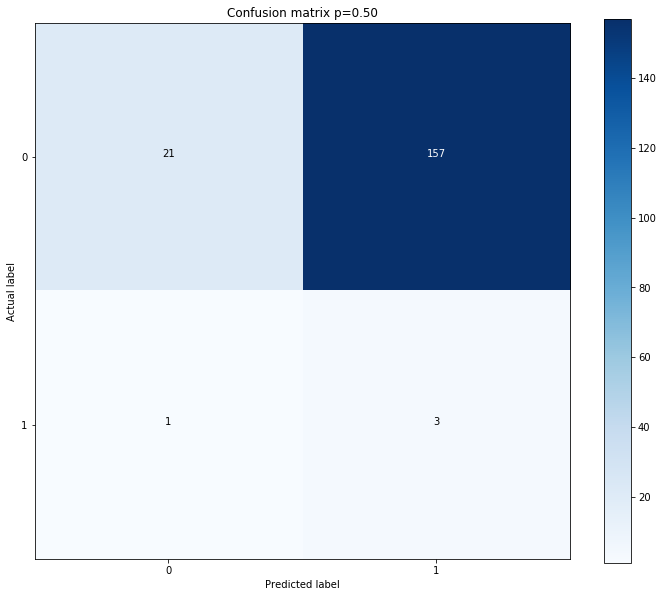

In [13]:
if __name__ == '__main__':
    cfg = yaml.full_load(open("/home/ubuntu/covid-cxr/config.yml", 'r'))
    cfg['TRAIN']['EXPERIMENT_TYPE']
    train_experiment(cfg=cfg, experiment=cfg['TRAIN']['EXPERIMENT_TYPE'], save_weights=True, write_logs=True)

In [14]:
import socket
## getting the hostname by socket.gethostname() method
hostname = socket.gethostname()
## getting the IP address using socket.gethostbyname() method
ip_address = socket.gethostbyname(hostname)
## printing the hostname and ip_address
print(f"Hostname: {hostname}")
print(f"IP Address: {ip_address}")

Hostname: ip-172-31-82-217
IP Address: 172.31.82.217


In [15]:
%load_ext tensorboard
%tensorboard --logdir /home/ubuntu/covid-cxr/results/logs --host {ip_address}



ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.